# Compare SVD analysis with PixelFLipping scores

### Imports

In [1]:
%load_ext autoreload
%autoreload 2

device = "cpu"
MNIST_CNN_PATH = './models/'
data_dir = "./dataset"
cat16_dir = data_dir + "/cat16"

import os
from tqdm import tqdm
import copy
from functools import partial

import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
# import seaborn as sns
# import pandas as pd

import quantus

from util.util_cnn import CNNModel, data_loaders, test, \
                params_to_filename, params_from_filename, \
                load_mnist_v4_models, first_mnist_batch

from util.util_gamma_rule import \
                forw_surrogate_matrix,  \
                back_matrix, \
                global_conv_matrix_from_pytorch_layer, \
                calc_evals_batch, \
                calc_vals_batch, \
                plot_vals_lineplot, \
                smart_gamma_wo_sign_flips, \
                col_norms_for_matrices

from util.quantus import batch_auc, batch_mean_auc, max_diff_replacement_by_indices

from util.util_gamma_layers import GammaPerNeuronLayer, GammaWoSignFlipsLayer, Conv2dAsMatrixLayer

from util.util_lrp import layerwise_forward_pass, compute_relevancies, LRP_global_mat, calc_mats_batch_functional, forward_and_explain
from util.util_data_summary import *
import util.util_tutorial as tut_utils

from util.naming import *
from util.util_pickle import *

/Users/jmaess/miniconda3/envs/msc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load models

In [2]:
# load v4 models
model_dict = load_mnist_v4_models()

# models_1 = {k:v for (k,v) in model_dict.items() if 'cb1-8' in k and 'seed-0' in k}
model_d3 = model_dict['cb1-8-8-8_cb2-16-16-16_seed-0']
model = model_d3

### Load data

In [3]:
data, target = first_mnist_batch()

A, layers = layerwise_forward_pass(model_d3, data)
L = len(layers)

A_shapes = [a.shape[1:] for a in A]

### Forward pass, define LRP modes, LRP backward passes

In [4]:
gamma_mode = 'cascading_gamma'
# gamma_mode = 'individual_gamma'

# gammas = gammas_0_1_21_inf
gammas = gammas40

if   gammas is gammas40:          g_str = 'gammas40'
elif gammas is gammas_0_1_21_inf: g_str = 'gammas_0_1_21_inf'
else: assert 0

modes = {0: 'LRP-0'}
for i, l_ub in enumerate(d3_after_conv_layer):
    for j, g in enumerate(gammas):
        if g=='inf': g = 1e8
        if g!=0:
            g = np.round(g, 8)
            if gamma_mode=='cascading_gamma':  modes[i*1000+j] = f'Gamma.            l<{l_ub} gamma={g}'
            if gamma_mode=='individual_gamma': modes[i*1000+j] = f'Gamma. l>{l_ub-2} l<{l_ub} gamma={g}'

if False: # recompute?
    relevancies_per_mode = {}
    for mode in tqdm(modes.values()):
        # if mode in relevancies_per_mode: continue
        rels = compute_relevancies(mode=mode, layers=layers, A=A, output_rels='correct class', target=target)
        if mode!="info": relevancies_per_mode[mode] = rels

    save_data('d3', f'Rels__m0_to_0__{gamma_mode}__{g_str}', relevancies_per_mode)
else:
    assert (relevancies_per_mode := load_data('d3', f'Rels__m0_to_0__{gamma_mode}__{g_str}'))

In [5]:
def rel(index):
    if type(index) in [int, float]:
        index = modes[index]
    elif type(index) is str:
        if index in modes.values():
            pass
        else:
            match = None
            for key in modes.values():
                if index in key:
                    assert match is None, f"Can not identify one unique mode with {index}: [{match}, {key}, ...]"
                    match = key

            assert match is not None, f"Can not identify any mode with {index}"
            index = match
    else: 
        raise "index must be of type str or numeric"
    return copy.deepcopy(relevancies_per_mode[index])

## Visualization

#### Visualization

In [149]:
layers_is = [6,5,3,2,0]
layers_is = [0]

shape: (1, 28, 28) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy 0.055674933


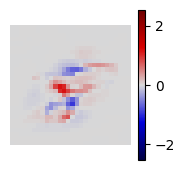

In [151]:
R = rel(0)

point_i = 0

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = np.array(R[l][point_i])
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean())
    tut_utils.heatmap(dat.sum(axis=0), 0.5*i+1.5, 0.5*i+1.5, colorbar=True)

#### Batched visualization

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0557, 0.0541, 0.0374, 0.0650, 0.0490, 0.0439])


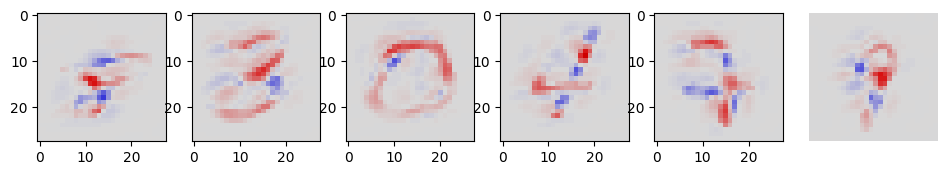

In [152]:
R = rel(0)

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0540, 0.0529, 0.0367, 0.0631, 0.0479, 0.0429])


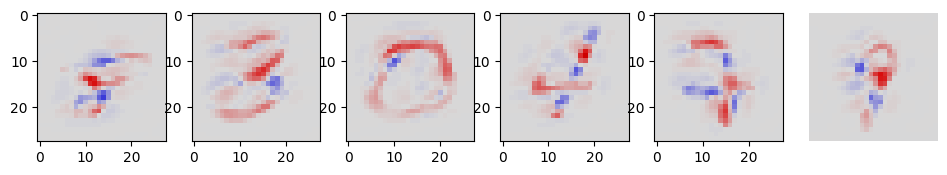

In [153]:
R = rel(1)

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0158, 0.0134, 0.0080, 0.0187, 0.0119, 0.0117])


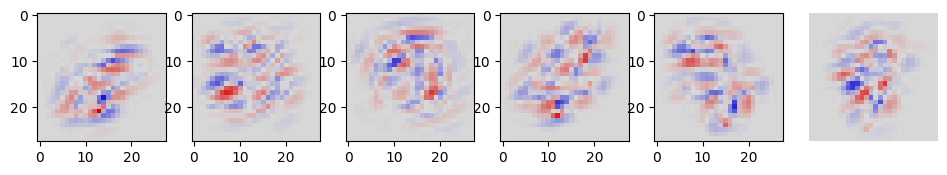

In [248]:
R1, R2 = rel('LRP-0'), rel('Gamma. l>1 l<3 gamma=1024.0')

for i,l in enumerate(layers_is):
    if R[l] is None: continue
    dat = R1[l][:6] - R2[l][:6]
    print("shape:", dat.shape, "- before layer", l, ':', layers[l])
    print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
    tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

LRP-0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0557, 0.0541, 0.0374, 0.0650, 0.0490, 0.0439])


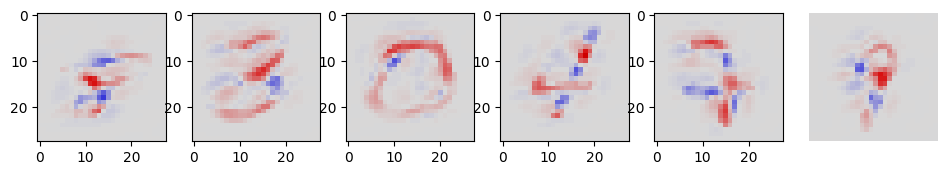

Gamma. l>1 l<3 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0458, 0.0451, 0.0329, 0.0526, 0.0419, 0.0376])


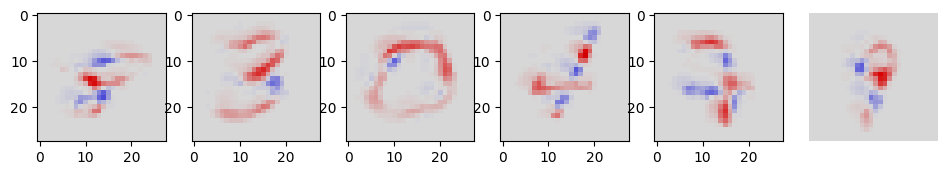

Gamma. l>3 l<5 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0279, 0.0385, 0.0281, 0.0374, 0.0335, 0.0276])


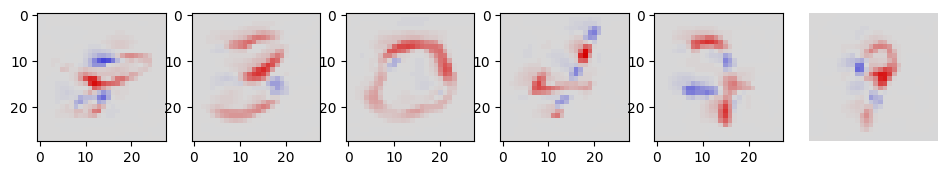

Gamma. l>6 l<8 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0167, 0.0326, 0.0259, 0.0225, 0.0206, 0.0194])


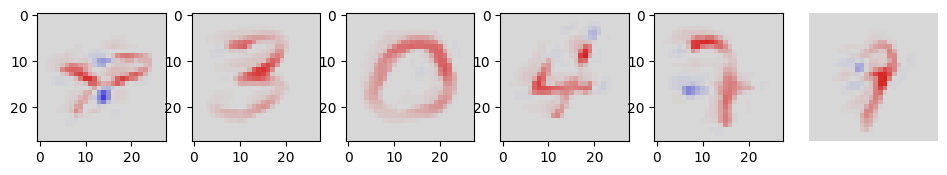

Gamma. l>8 l<10 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0214, 0.0364, 0.0278, 0.0263, 0.0204, 0.0194])


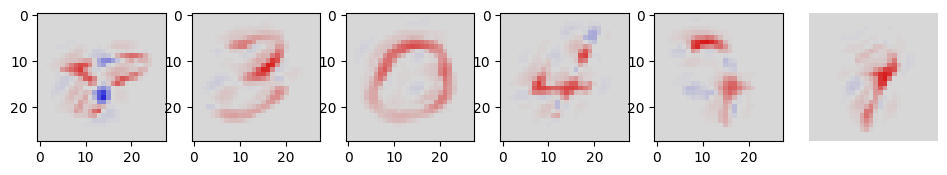

Gamma. l>10 l<12 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0216, 0.0390, 0.0298, 0.0282, 0.0209, 0.0221])


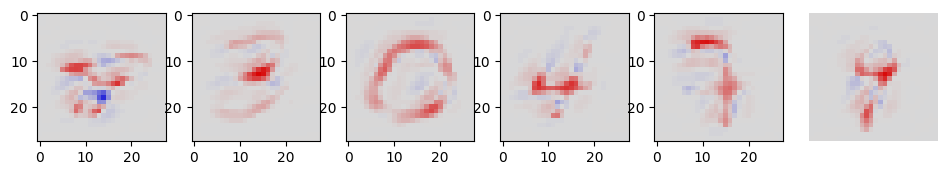

Gamma. l>14 l<16 gamma=1024.0
shape: torch.Size([6, 1, 28, 28]) - before layer 0 : Conv2d(1, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
mean absolute relevancy tensor([0.0249, 0.0450, 0.0369, 0.0361, 0.0260, 0.0282])


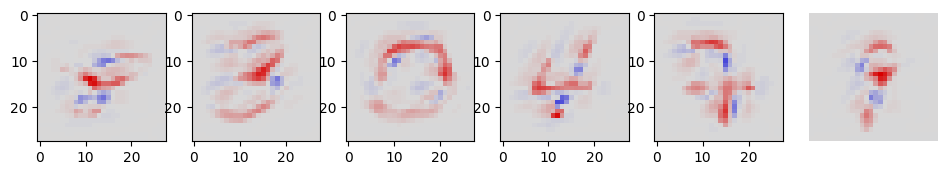

In [249]:
for mode in modes.values():
    if 'gamma=1024.0' not in mode and 'LRP-0' not in mode: continue
    print(mode)
    R = rel(mode)

    for i,l in enumerate(layers_is):
        if R[l] is None: continue
        dat = R[l][:6]
        print("shape:", dat.shape, "- before layer", l, ':', layers[l])
        print("mean absolute relevancy", np.abs(dat).mean(axis=(1,2,3)))
        tut_utils.heatmap_batch(dat.sum(axis=1), 0.5*i+1.5, 0.5*i+1.5)

# Quantus Pixelflipping implementation

### Common

In [87]:
y_batch = target.detach().numpy()
x_batch =   data.detach().numpy().reshape((100, 1, 28, 28))

# Decorate the function with lru_cache
@functools.lru_cache(maxsize=100)
def pf_main(baseline, mode='individual', gammas='gammas40'):
    key = f'PixFlipScores__{baseline}__{mode}_gamma__{gammas}'
    if gammas=='gammas40': gammas = gammas40
    elif gammas=='gamma_0_1_21_inf': gammas = gammas_0_1_21_inf
    else: assert 0, "invalid gammas"

    # key = 'PixFlipScores_gamma_0_1_21_inf'

    batch_scores = load_data('d3', key)

    print('shape:', np.array(batch_scores['LRP-0']['PixFlip']).shape)

    experiment_dict = {}

    for mode_str, mode_dict in batch_scores.items():
        experiment_dict[mode_str] = {}
        for method_str, method_scores in mode_dict.items():
            if 'AUC' in method_str: continue
            experiment_dict[mode_str][method_str + ' AUC (per sample)'] =      batch_auc(method_scores)
            experiment_dict[mode_str][method_str + ' AUC (batch mean)'] = batch_mean_auc(method_scores)

        # experiment_dict[mode_str]['Layerwise Relevancies'] = relevancies_per_mode[mode_str]
        
    experiment_dict['x_batch'] = x_batch
    experiment_dict['y_batch'] = y_batch


    ### prep plotting

    k = len(next(iter(experiment_dict.values()))['PixFlip AUC (per sample)'])

    aucs =      np.zeros((len(d3_after_conv_layer), k, len(gammas), 1))
    auc_means = np.zeros((len(d3_after_conv_layer), 1, len(gammas), 1))

    l_keys = []
    for key in experiment_dict.keys():
        if 'Gamma.' in key:
            key = key.split('gamma=')[0]
            if key not in l_keys:
                l_keys.append(key)

    for i, l_key in enumerate(l_keys):
        modes_sorted = dict()
        if 0 in gammas: modes_sorted[0] = 'LRP-0'
        for mode_str in experiment_dict.keys():
            if l_key in mode_str:
                g = float(mode_str.split('gamma=')[1])
                modes_sorted[g] = mode_str
        assert len(modes_sorted) == len(gammas)

        for j, mode_str in enumerate(modes_sorted.values()):
            aucs[i, :, j, 0] =      experiment_dict[mode_str]['PixFlip AUC (per sample)']
            auc_means[i, 0, j, 0] = experiment_dict[mode_str]['PixFlip AUC (batch mean)']

    return experiment_dict, aucs, auc_means

def pf_auc_mean(baseline, **kwargs):
    return pf_main(baseline, **kwargs)[2]

def pf_auc(baseline, **kwargs):
    return pf_main(baseline, **kwargs)[1]

### Reconstruct old results

In [70]:
np.array(load_data('d3', key)['LRP-0']['PixFlip']).shape

(95, 784)

In [69]:
load_data('d3', key)['LRP-0'].keys()

dict_keys(['PixFlip'])

In [63]:
correction_mask = (target.detach().numpy() == y_batch)
print("Fraction of useful scores:", correction_mask.mean())

Fraction of useful scores: 0.95


In [64]:
experiment_dict={}
for mode_str in tqdm(batch_scores.keys()):
    methods = list(batch_scores[mode_str].keys())
    for method in methods:
        experiment_dict[mode_str] = {}
        experiment_dict[mode_str][method] = np.array(batch_scores[mode_str][method])[correction_mask]

100%|██████████| 127/127 [00:00<00:00, 385.03it/s]


(<Figure size 2500x300 with 5 Axes>,
 array([<AxesSubplot: xlabel='$\\gamma$', ylabel='AUC batch mean'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>], dtype=object))

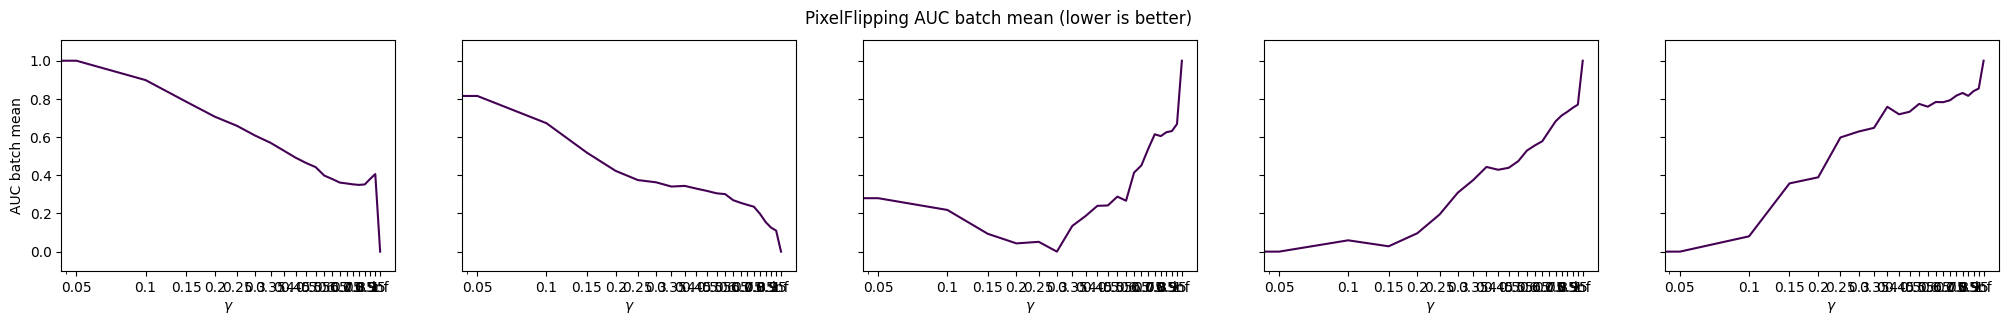

In [89]:
auc_means = pf_auc_mean('black', mode='cascading', gammas='gamma_0_1_21_inf')
auc_means -= auc_means.min(axis=(1,2), keepdims=True)
auc_means /= auc_means.max(axis=(1,2), keepdims=True)

plot_vals_lineplot(auc_means, dice=(-1,), 
                       xscale='log', 
                       yscale='linear', ylim=(0, 1),
                        ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True)

2600


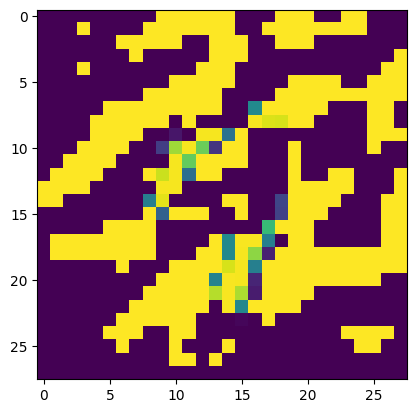

AssertionError: 

In [194]:
k = None # num points = all
k = 4

pixFlipMetric = quantus.PixelFlipping(disable_warnings = False, 
                                      perturb_func=max_diff_replacement_by_indices, 
                                      perturb_baseline='black')

def flipScores(a_batch, j=None, k=None):
    if k==None: k=len(a_batch)
    return pixFlipMetric(
        model=model,
        x_batch=x_batch[j:k],
        y_batch=y_batch[j:k],
        a_batch=a_batch[j:k],
        device=device
    )

mode_list = sorted(modes.values())



# mode_list = ['LRP-0', 'Gamma. l<12 gamma=0.125', 'Gamma. l<12 gamma=0.25', 'Gamma. l<12 gamma=0.5', 'Gamma. l<12 gamma=inf']

model.eval()
mode_str = 'LRP-0'
mode_str = 'Gamma. l>1 l<8 gamma=1024'
mode_str = 'l<10 gamma=0.001'

count = 1
batch_scores = { mode_str: { 'PixFlip': flipScores(rel(mode_str)[0].numpy(), k=3, j=2) } }

### all in one
# batch_scores = { mode_str: { 'PixFlip': flipScores(rel(mode_str)[0].numpy(), k) } for mode_str in tqdm(mode_list) }
# save_data('d3', 'PixFlipScores_gammas40', batch_scores)

# ### partitioned
# for i, mode_str in enumerate(mode_list):
#     print(i, mode_str)
#     model.eval()
#     batch_scores = { mode_str: { 'PixFlip': flipScores(rel(mode_str)[0].numpy(), k) } }
#     # save_data('d3', 'PixFlipScores__individual_gamma__gammas40', batch_scores, partition=(0, i))

#### Load data and calculate statistics

In [173]:
if gammas is gammas_0_1_21_inf:
    print('gammas_0_1_21_inf')
    batch_scores = load_data('d3', 'PixFlipScores_gamma_0_1_21_inf')

    # unfortunately I made a mistake. The Pix Flip scores are computed wrt. the correct class "taget", but the explanations are for the predicted class "y_batch". Mask out those where this is not equal.
    correction_mask = (target.detach().numpy() == y_batch)
    print("Fraction of useful scores:", correction_mask.mean())
    
    corrected_scores={}
    for mode_str in tqdm(batch_scores.keys()):
        methods = list(batch_scores[mode_str].keys())
        for method in methods:
            corrected_scores[mode_str] = {}
            corrected_scores[mode_str][method] = np.array(batch_scores[mode_str][method])[correction_mask]

    # delete LRP-0 duplicates
    

    batch_scores = corrected_scores

elif gammas is gammas40:
    print('gammas40')
    batch_scores = load_data('d3', 'PixFlipScores__black__individual_gamma__gammas40')

batch_scores.keys(), next(iter(batch_scores.values())).keys()

gammas40


(dict_keys(['LRP-0', 'Gamma. l>1 l<3 gamma=1e-05', 'Gamma. l>1 l<3 gamma=3e-05', 'Gamma. l>1 l<3 gamma=0.0001', 'Gamma. l>1 l<3 gamma=0.0003', 'Gamma. l>1 l<3 gamma=0.001', 'Gamma. l>1 l<3 gamma=0.0025', 'Gamma. l>1 l<3 gamma=0.004', 'Gamma. l>1 l<3 gamma=0.0055', 'Gamma. l>1 l<3 gamma=0.007', 'Gamma. l>1 l<3 gamma=0.0085', 'Gamma. l>1 l<3 gamma=0.01', 'Gamma. l>1 l<3 gamma=0.01666667', 'Gamma. l>1 l<3 gamma=0.02333333', 'Gamma. l>1 l<3 gamma=0.03', 'Gamma. l>1 l<3 gamma=0.03666667', 'Gamma. l>1 l<3 gamma=0.04333333', 'Gamma. l>1 l<3 gamma=0.05', 'Gamma. l>1 l<3 gamma=0.075', 'Gamma. l>1 l<3 gamma=0.1', 'Gamma. l>1 l<3 gamma=0.125', 'Gamma. l>1 l<3 gamma=0.15', 'Gamma. l>1 l<3 gamma=0.175', 'Gamma. l>1 l<3 gamma=0.2', 'Gamma. l>1 l<3 gamma=0.33333333', 'Gamma. l>1 l<3 gamma=0.46666667', 'Gamma. l>1 l<3 gamma=0.6', 'Gamma. l>1 l<3 gamma=0.73333333', 'Gamma. l>1 l<3 gamma=0.86666667', 'Gamma. l>1 l<3 gamma=1.0', 'Gamma. l>1 l<3 gamma=2.0', 'Gamma. l>1 l<3 gamma=4.0', 'Gamma. l>1 l<3 gamm

In [36]:
batch_scores = load_data('d3', 'PixFlipScores__black__individual_gamma__gammas40')
print(batch_scores.keys().__len__())

235


In [150]:
baseline = 'max_diff'

key = f'PixFlipScores__{baseline}__individual_gamma__gammas40'
key = f'PixFlipScores__{baseline}__cascading_gamma__gammas40'

batch_scores = load_data('d3', key, partitioned=True)
n = len(batch_scores.keys())
assert n == 235, n
save_data('d3', key, batch_scores)

batch_scores = load_data('d3', key)
print(batch_scores.keys().__len__())

235


### Plot PixFlip performance

<Figure size 640x480 with 0 Axes>

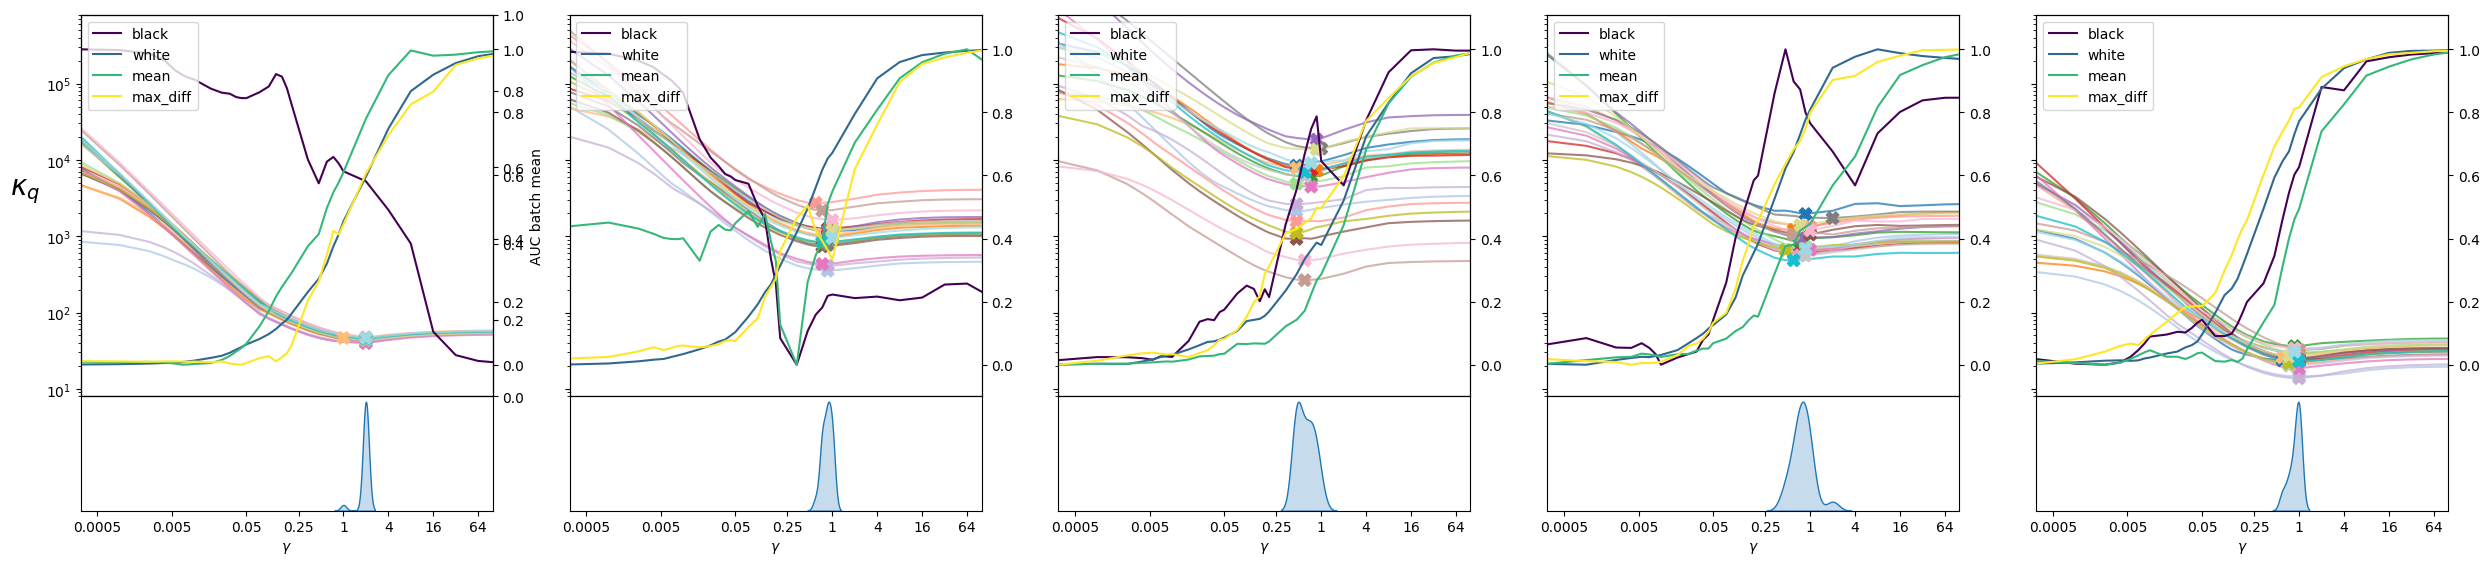

In [13]:
ticks = [5e-4, 5e-3, 5e-2, .25, 1, 4, 16, 64]
fig, axs = plot_condition_number(('d3', 'svals__individual_layer__gammas40'), percentile=(0, .05), 
                                 mode='combined', xlim=(3e-4, 100), ylim=(8, 8e5), ticks=ticks)

mode = 'individual'
baselines = ['black', 'white', 'mean', 'max_diff']
auc_means = np.concatenate([pf_auc_mean(baseline, mode=mode) for baseline in baselines], axis=3)
auc_means -= auc_means.min(axis=(1,2), keepdims=True)
auc_means /= auc_means.max(axis=(1,2), keepdims=True)

plot_vals_lineplot(auc_means, dice=(-1,), axes=axs,
                       xscale='log', yscale='linear', ylim=(0, 1),
                        ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True, tag_line=baselines, legend="upper left")

plt.show()

(<Figure size 2500x300 with 5 Axes>,
 array([<AxesSubplot: xlabel='$\\gamma$', ylabel='AUC batch mean'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>], dtype=object))

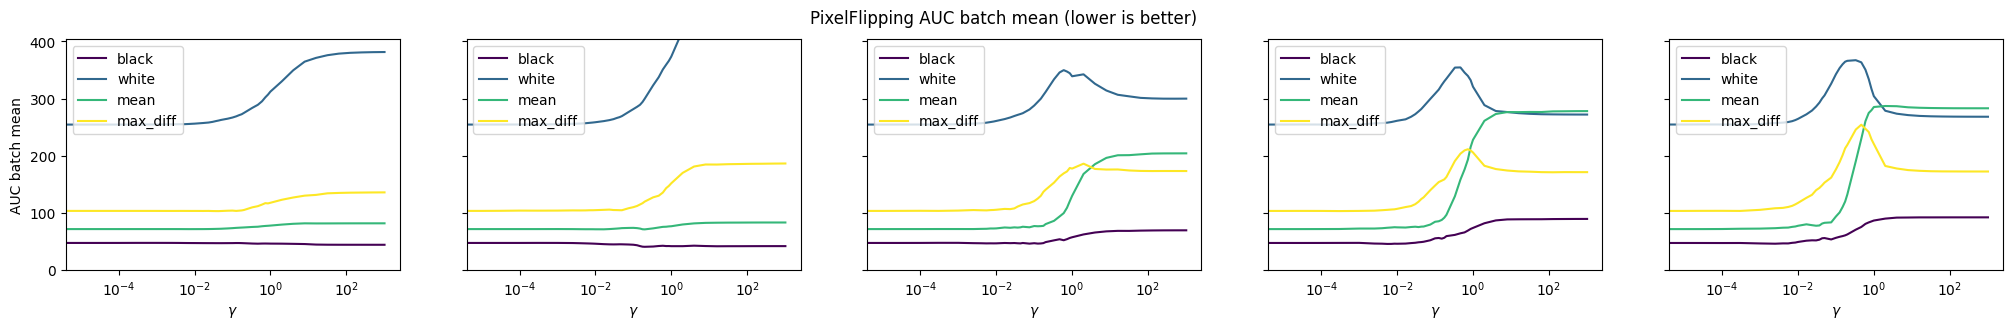

In [93]:
mode = 'cascading'
norm = False

baselines = ['black', 'white', 'mean', 'max_diff']
auc_means = np.concatenate([pf_auc_mean(baseline, mode=mode) for baseline in baselines], axis=3)
if norm:
    auc_means -= auc_means.min(axis=(1,2), keepdims=True)
    auc_means /= auc_means.max(axis=(1,2), keepdims=True)

plot_vals_lineplot(auc_means, dice=(-1,), 
                       xscale='log', yscale='linear', ylim=(0, 1) if norm else (0, 400),
                        ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True, tag_line=baselines, legend="upper left")

(<Figure size 2500x300 with 5 Axes>,
 array([<AxesSubplot: xlabel='$\\gamma$', ylabel='AUC batch mean'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>], dtype=object))

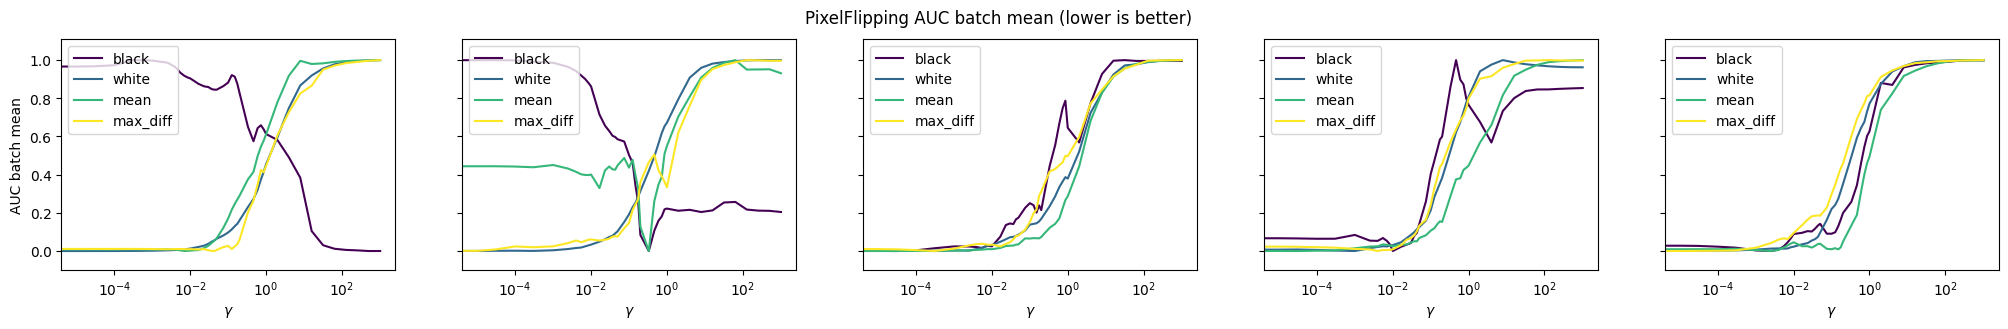

In [256]:
mode = 'individual'
baselines = ['black', 'white', 'mean', 'max_diff']
auc_means = np.concatenate([pf_auc_mean(baseline, mode=mode) for baseline in baselines], axis=3)
auc_means -= auc_means.min(axis=(1,2), keepdims=True)
auc_means /= auc_means.max(axis=(1,2), keepdims=True)

plot_vals_lineplot(auc_means, dice=(-1,), 
                       xscale='log', yscale='linear', ylim=(0, 1),
                        ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True, tag_line=baselines, legend="upper left")

In [241]:
auc_means.min(axis=(1,2), keepdims=True).shape


(6, 1, 1, 4)

/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_

<Figure size 640x480 with 0 Axes>

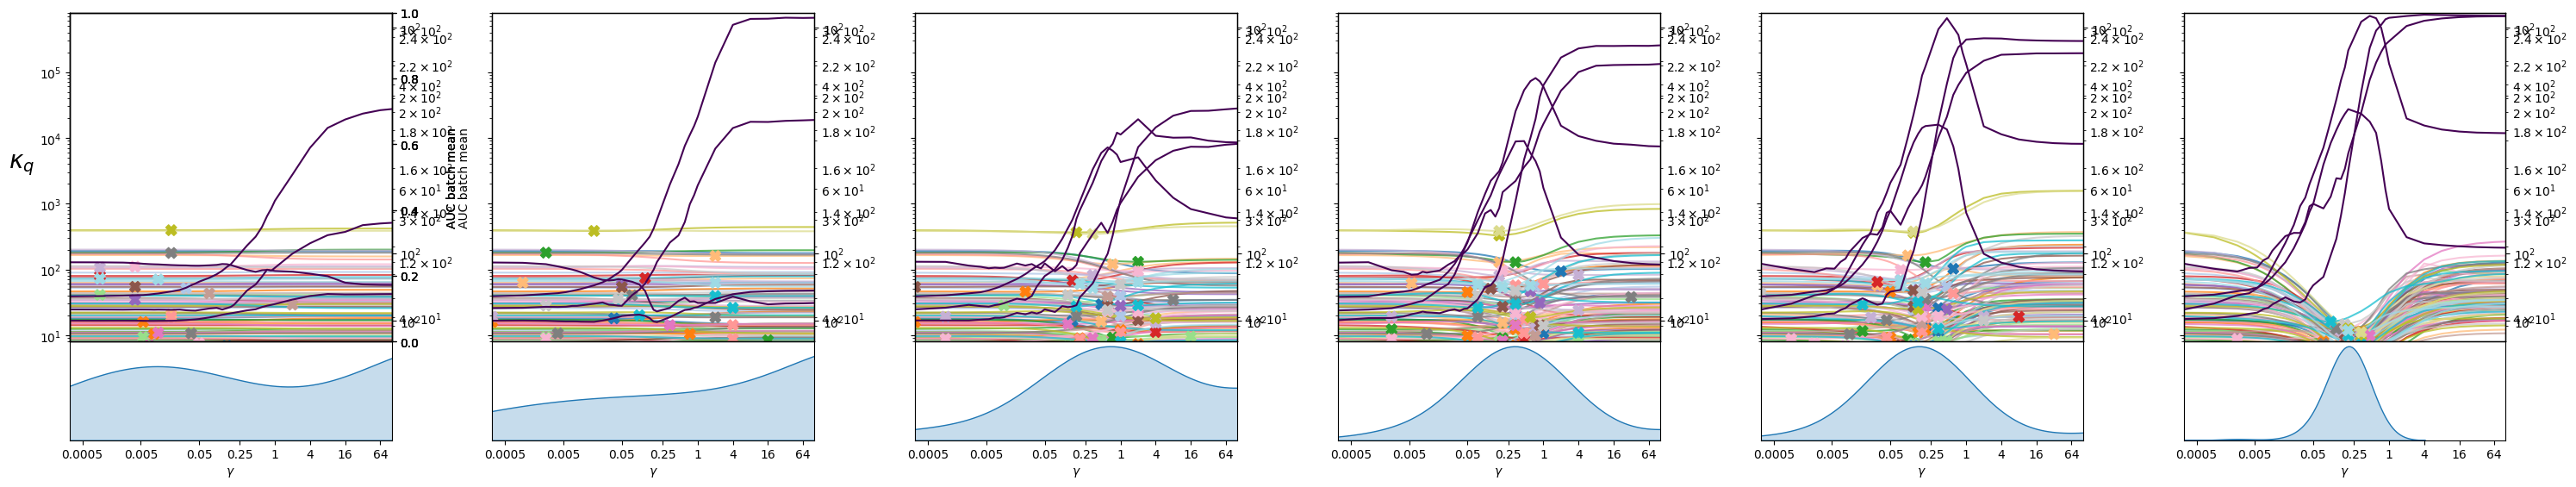

In [ ]:
ticks = [5e-4, 5e-3, 5e-2, .25, 1, 4, 16, 64]
fig, axs = plot_condition_number(('d3', 'svals__m0_to_1__cascading_gamma__gammas40'), percentile=(0, .05), 
                                 mode='combined', xlim=(3e-4, 100), ylim=(8, 8e5), ticks=ticks)

mode = 'cascading'
for baseline in ['black', 'white', 'mean', 'max_diff']:
    m = pf_auc_mean(baseline, mode=mode)
    plot_vals_lineplot(m, axes = axs, 
                       xscale='log', yscale='log', ylim=(m.min(), m.max()),
                        ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True)

plt.show()

/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_data_summary.py:503: RuntimeWarning: divide by zero encountered in log10
  sns.kdeplot(x=np.log10(g), bw_method=.6, ax=ax_histx, fill=True)
/Users/jmaess/Repositories/Masterarbeit/util/util_

(<Figure size 3000x600 with 6 Axes>,
 [<AxesSubplot: ylabel='$\\kappa_q$'>,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >,
  <AxesSubplot: >])

<Figure size 640x480 with 0 Axes>

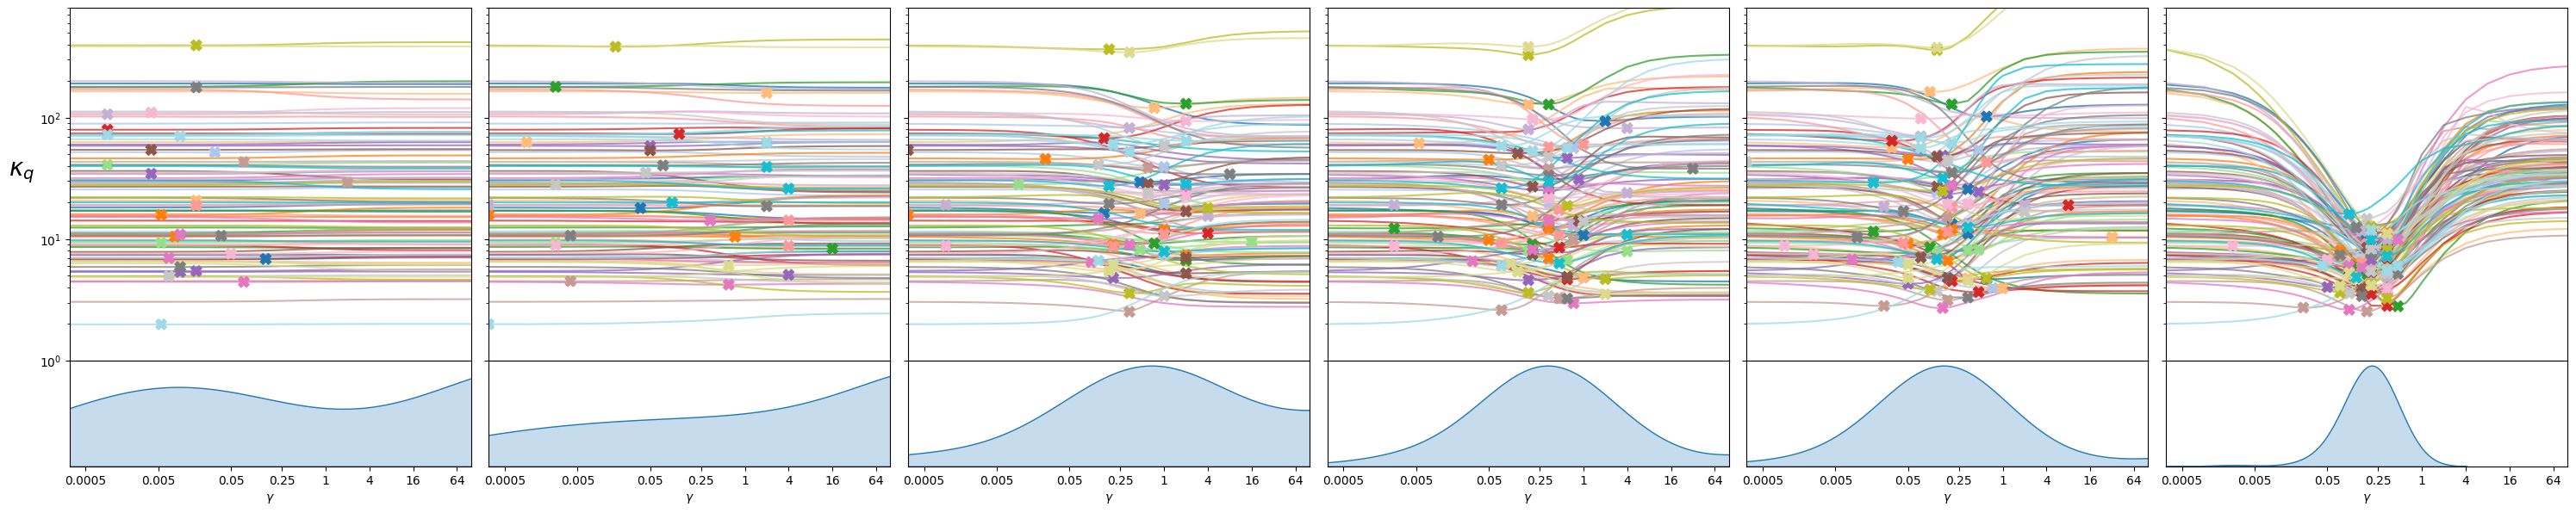

In [123]:
# condition number doesn't work well when gmamma is to only a subset of the analysed layers.
plot_condition_number(('d3', 'svals__m0_to_1__cascading_gamma__gammas40'), percentile=(.0, .05), 
                        mode='combined', xlim=(3e-4, 100), ylim=(1, 8e2), ticks=ticks)

(<Figure size 3000x300 with 6 Axes>,
 array([<AxesSubplot: xlabel='$\\gamma$', ylabel='AUC batch mean'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>], dtype=object))

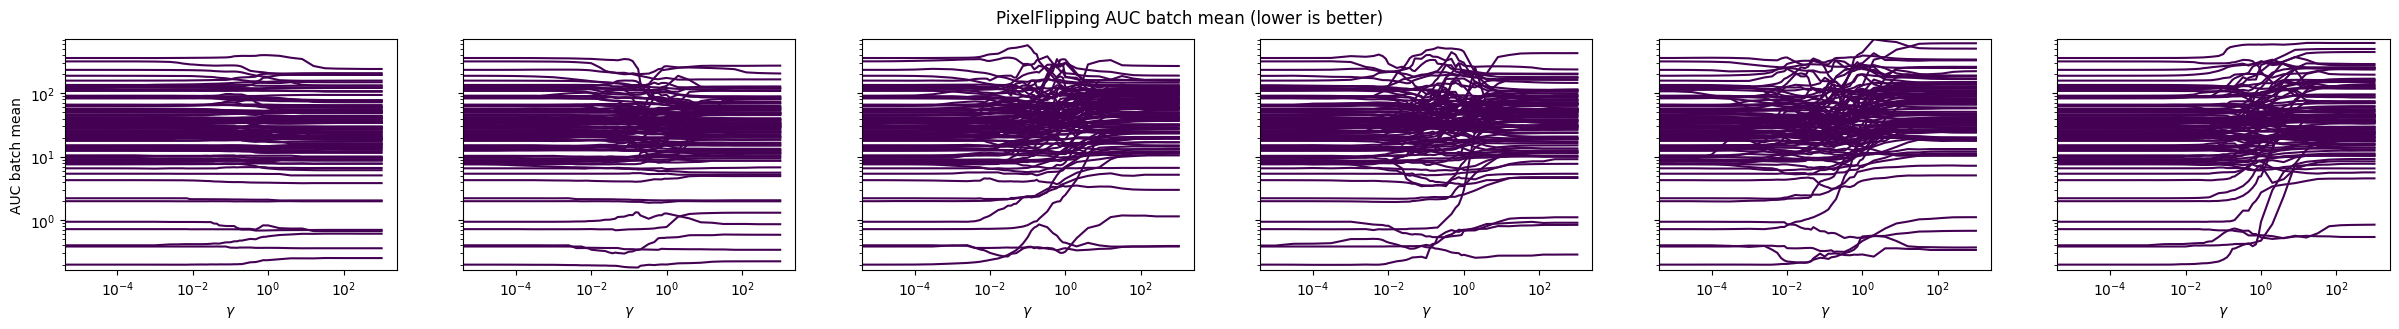

In [121]:
plot_vals_lineplot(aucs, ylim=(aucs.min(), aucs.max()), xscale='log', yscale='log', 
                    ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True)

(<Figure size 3000x300 with 6 Axes>,
 array([<AxesSubplot: xlabel='$\\gamma$', ylabel='$\\frac{ \\sigma_i(\\gamma) }{ \\sigma_i(0) }$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>,
        <AxesSubplot: xlabel='$\\gamma$'>], dtype=object))

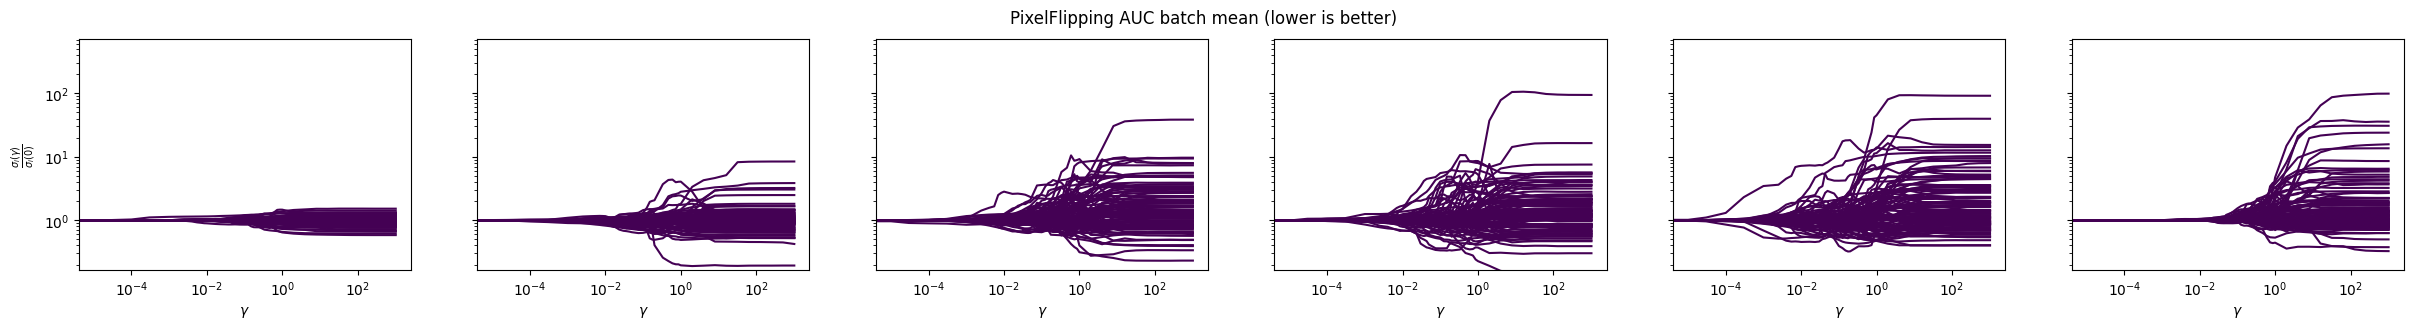

In [30]:
plot_vals_lineplot(aucs, ylim=(aucs.min(), aucs.max()), xscale='log', yscale='log', norm_g0=True,
                    ylabel="AUC batch mean", title="PixelFlipping AUC batch mean (lower is better)", sharey=True)

(<Figure size 6000x400 with 6 Axes>,
 array([[<AxesSubplot: title={'center': 'w0 p[0, 99]. Distribution of 100 non-zero Singular values for 40 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w1 p[0, 99]. Distribution of 100 non-zero Singular values for 40 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w2 p[0, 99]. Distribution of 100 non-zero Singular values for 40 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w3 p[0, 99]. Distribution of 100 non-zero Singular values for 40 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w4 p[0, 99]. Distribution of 100 non-zero Singular values for 40 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w5 p[0, 99]. Distribution of 100 non-zero Singular values for 40 gammas.'}, xlabel='$\\gamma$'>]],
       dtype=object))

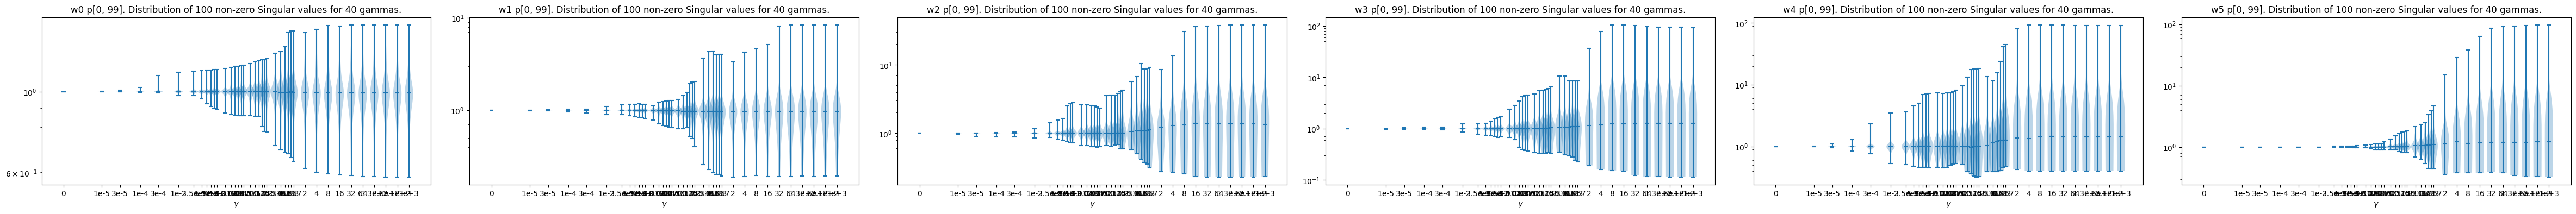

In [29]:
distribution_plot(aucs, aggregate_over='points', mode='violin', norm_g0=True)

(<Figure size 6000x400 with 6 Axes>,
 array([[<AxesSubplot: title={'center': 'w0 p[0, 99]. Distribution of 100 non-zero Singular values for 26 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w1 p[0, 99]. Distribution of 100 non-zero Singular values for 26 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w2 p[0, 99]. Distribution of 100 non-zero Singular values for 26 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w3 p[0, 99]. Distribution of 100 non-zero Singular values for 26 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w4 p[0, 99]. Distribution of 100 non-zero Singular values for 26 gammas.'}, xlabel='$\\gamma$'>],
        [<AxesSubplot: title={'center': 'w5 p[0, 99]. Distribution of 100 non-zero Singular values for 26 gammas.'}, xlabel='$\\gamma$'>]],
       dtype=object))

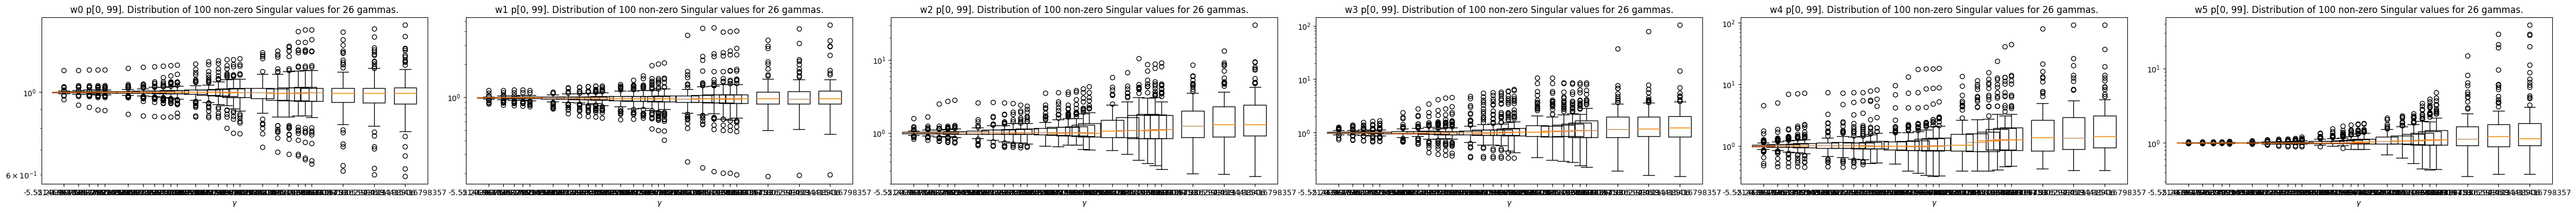

In [33]:
distribution_plot(aucs, aggregate_over='points', mode='box', norm_g0=True, dice=((),(), (7, -7)))

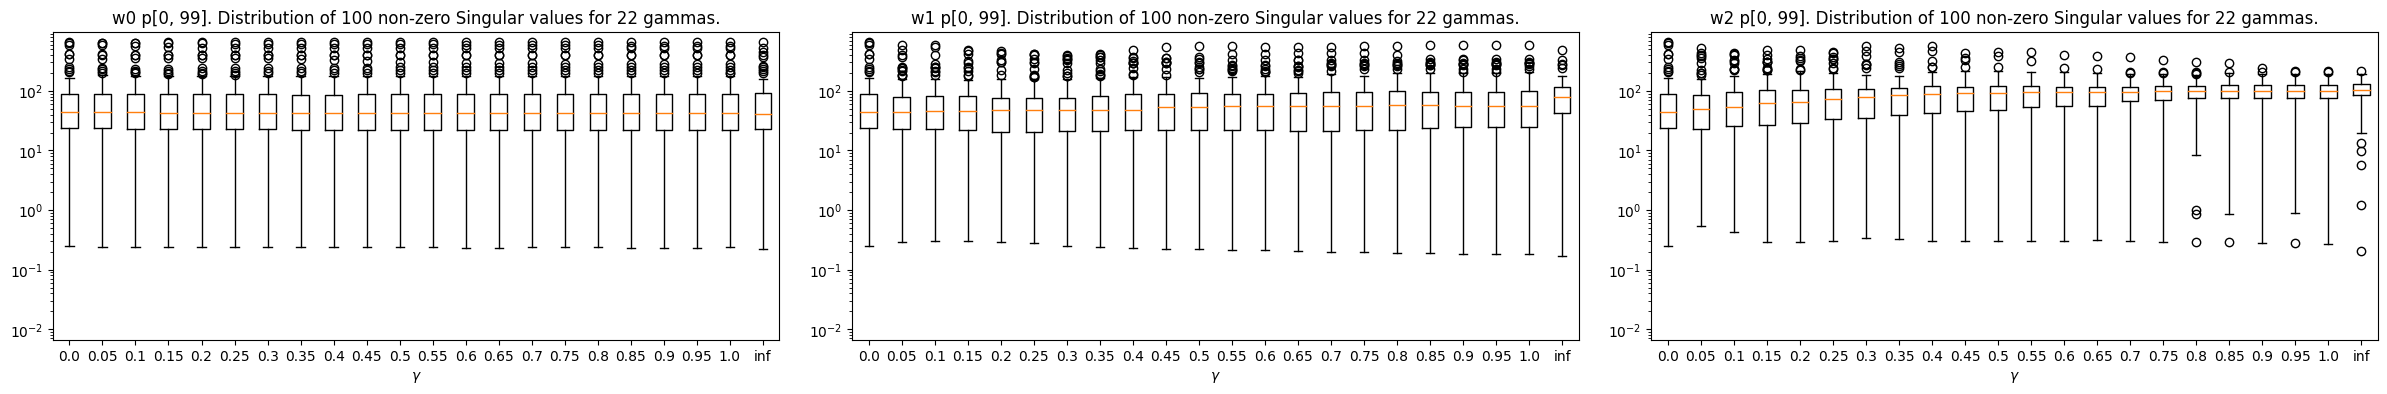

In [242]:
distribution_plot(aucs[[0,2,4]], gammas_0_1_21_inf, aggregate_over='points', mode='box')

### Playground

### Plot individual PixFlipScores

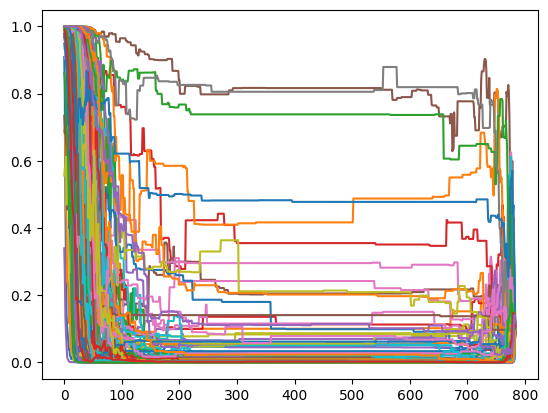

In [298]:
# pixel flip scores for LRP-0
scores = experiment_dict['LRP-0']['PixFlip']
scores = np.array(scores)
print(scores.shape)
plt.plot(scores.T);

(100, 784)


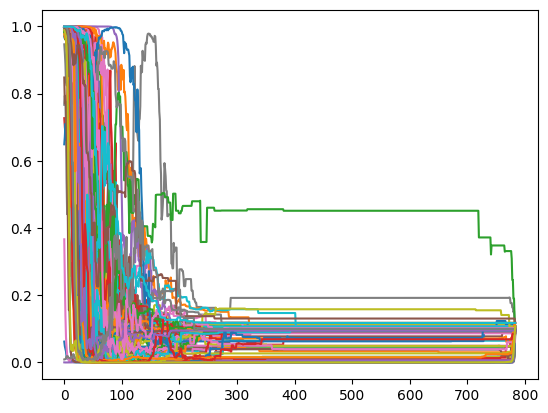

In [101]:
# pixel flip scores for Gamma. l<12 gamma=0.25
scores = batch_scores['Gamma. l<12 gamma=0.7']['PixFlip']
# scores = batch_scores['LRP-0']['PixFlip']
scores = np.array(scores)
print(scores.shape)
plt.plot(scores.T);

In [99]:
batch_scores.keys()

dict_keys(['LRP-0', 'Gamma. l<3 gamma=0.05', 'Gamma. l<3 gamma=0.1', 'Gamma. l<3 gamma=0.15', 'Gamma. l<3 gamma=0.2', 'Gamma. l<3 gamma=0.25', 'Gamma. l<3 gamma=0.3', 'Gamma. l<3 gamma=0.35', 'Gamma. l<3 gamma=0.4', 'Gamma. l<3 gamma=0.45', 'Gamma. l<3 gamma=0.5', 'Gamma. l<3 gamma=0.55', 'Gamma. l<3 gamma=0.6', 'Gamma. l<3 gamma=0.65', 'Gamma. l<3 gamma=0.7', 'Gamma. l<3 gamma=0.75', 'Gamma. l<3 gamma=0.8', 'Gamma. l<3 gamma=0.85', 'Gamma. l<3 gamma=0.9', 'Gamma. l<3 gamma=0.95', 'Gamma. l<3 gamma=1.0', 'Gamma. l<3 gamma=inf', 'Gamma. l<5 gamma=0.05', 'Gamma. l<5 gamma=0.1', 'Gamma. l<5 gamma=0.15', 'Gamma. l<5 gamma=0.2', 'Gamma. l<5 gamma=0.25', 'Gamma. l<5 gamma=0.3', 'Gamma. l<5 gamma=0.35', 'Gamma. l<5 gamma=0.4', 'Gamma. l<5 gamma=0.45', 'Gamma. l<5 gamma=0.5', 'Gamma. l<5 gamma=0.55', 'Gamma. l<5 gamma=0.6', 'Gamma. l<5 gamma=0.65', 'Gamma. l<5 gamma=0.7', 'Gamma. l<5 gamma=0.75', 'Gamma. l<5 gamma=0.8', 'Gamma. l<5 gamma=0.85', 'Gamma. l<5 gamma=0.9', 'Gamma. l<5 gamma=0.95', 